# Prediction des elections EUR (ML)

In [ ]:
import pandas as pd
import numpy as np

## Nettoyage du CSV eur

In [ ]:
df = pd.read_csv('csv/eur_1994.csv', delimiter=',')

df.dropna(how="all", inplace=True)
for col in df.columns[3:]:
    if 'Vot/Ins' in col or '% Voix/Ins' in col or '% Voix/Exp' in col:
        df[col] = df[col].str.rstrip('%').astype('float') / 100
features = ['% Abs/Ins', '% Vot/Ins', '% BlNuls/Ins', '% BlNuls/Vot']
target = '% Voix/Ins'

df_features = df[features + [target]]
print(df_features.head())


## Nettoyage chomage

In [ ]:
def update_unemployment_data(source_file_path, chomage_file_path):
    source_df = pd.read_csv(source_file_path, delimiter=',', header=0)
    chomage_df = pd.read_csv(chomage_file_path, delimiter=',')
    source_years = source_df['Annee'].unique().astype(int)
    filtered_chomage_df = chomage_df[chomage_df['Trimestre'].apply(lambda x: int(x.split('-')[0]))].reset_index(drop=True)

    merged_df = pd.merge(source_df, filtered_chomage_df[['Trimestre', 'France (hors Mayotte)']], left_on='Annee', right_on='Trimestre', how='left').drop(columns=['Trimestre'])
    merged_df.rename(columns={'France (hors Mayotte)': 'Unemployment_Rate'}, inplace=True)
    merged_df['Average_Unemployment_Rate'] = merged_df.groupby('Annee')['Unemployment_Rate'].transform(lambda x: x.mean())
    merged_df.dropna(subset=['Unemployment_Rate'], inplace=True)

    merged_df.to_csv('updated_dataset.csv', index=False)

source_file_path = 'centralise.csv'
chomage_file_path = './csv/chomage.csv'

update_unemployment_data(source_file_path, chomage_file_path)


## Nettoyage indice prix consommation

In [43]:

df_ipc = pd.read_csv('./csv/indice-prix-consommation.csv')
df_ipc['date'] = pd.to_datetime(df_ipc['date'])
df_ipc['annee'] = df_ipc['date'].dt.year

moyennes_ipc = df_ipc.groupby('annee')['ipc'].mean()

df_ipc_moyennes = pd.DataFrame({'Annee': moyennes_ipc.index, 'IPC_Moyenne': moyennes_ipc.values})

df_centralise = pd.read_csv('centralise.csv')

print("Colonnes dans df_centralise:", df_centralise.columns)
print("Colonnes dans df_ipc_moyennes:", df_ipc_moyennes.columns)

try:
    df_final = pd.merge(df_centralise, df_ipc_moyennes, on='Annee', how='left')
except KeyError as e:
    print(f"Erreur lors de la fusion : {e}")
else:
    df_final.to_csv('centralise.csv', index=False)




Colonnes dans df_centralise: Index(['Annee', 'Chomage'], dtype='object')
Colonnes dans df_ipc_moyennes: Index(['Annee', 'IPC_Moyenne'], dtype='object')


## Nettoyage recrutement CDD/CDI

In [50]:
df_nbr_emplye = pd.read_csv('./csv/nbr_employe_par_an.csv', delimiter=';')


sommes_dpae_brut = df_nbr_emplye.groupby('annee')['dpae_brut'].sum()
df_sommes_dpae_brut = pd.DataFrame({'Annee': sommes_dpae_brut.index, 'Somme_DPAE_Brut': sommes_dpae_brut.values})
df_sommes_dpae_brut['Somme_DPAE_Brut'] = df_sommes_dpae_brut['Somme_DPAE_Brut']

df_centralise = pd.read_csv('centralise.csv')
df_final = pd.merge(df_centralise, df_sommes_dpae_brut, on='Annee', how='left')

df_final.to_csv('centralise.csv', index=False)


## Résultat de vote par année pour les elections européen Droite ou gauche

In [ ]:
election_results = pd.read_csv('./csv/eur_1994.csv', delimiter=',', encoding='utf-8')

party_orientations = {
    "LUTTE OUVRIERE": "Gauche",
    "PARTI DES TRAVAILL.": "Gauche",
    "PCF": "Gauche",
    "EUROPE SOLIDAIRE": "Gauche",
    "AUTRE POLITIQUE": "Gauche",
    "ENERGIE RADICALE": "Gauche",
    "UNION DES ECOLOG.": "Gauche",
    "GENERATION ECOLOGIE": "Gauche",
    "RASS. OUTRE MER": "Droite",
    "REG ET FEDER": "Centre",
    "CHASSEURS": "Centre",
    "DEM E-U EUROPE": "Centre",
    "EUROPE POUR TOUS": "Centre",
    "L' EMPLOI D' ABORD": "Centre",
    "PARTI LOI NATURELLE": "N/A",
    "POLIT. DE VIE": "N/A",
    "SARAJEVO": "Gauche",
    "UDF-RPR": "Droite",
    "AUTRE EUROPE": "N/A",
    "FRONT NATIONAL": "Droite"
}

votes_per_orientation = election_results.groupby(election_results['Libellé Abrégé Liste']).map(party_orientations).value_counts()

winning_orientation = votes_per_orientation.idxmax()

print(f"The winning political orientation in 1994 is: {winning_orientation}")


## Heatmap

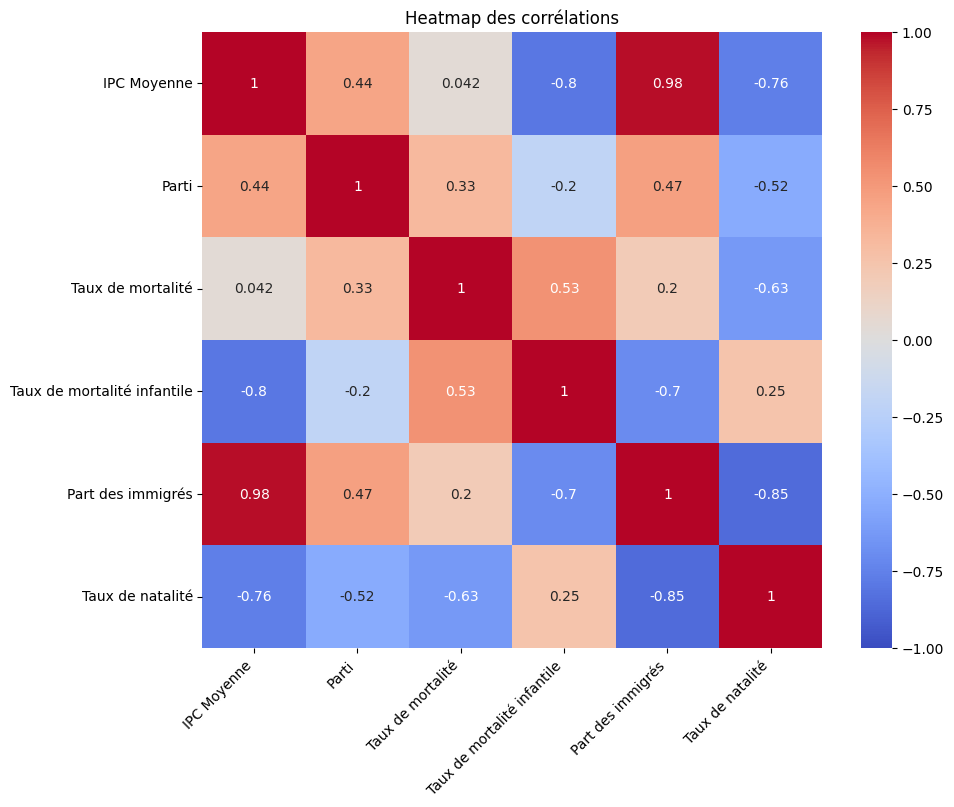

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('centralise.csv')

parti_mapping = {'Droite': 1, 'Gauche': 2, 'Centre': 3}
df['Parti_Num'] = df['Parti'].map(parti_mapping)

corr = df[['IPC_Moyenne', 'Parti_Num', 'Taux de mortalite %', 'Taux de mortalite infantile en %', 
           'Part des immigres dans la population %', 'Taux de natalite en France de 1982 e 2022 (pour 1.000 habitants)']].corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                      xticklabels=['IPC Moyenne', 'Parti', 'Taux de mortalité', 'Taux de mortalité infantile', 'Part des immigrés', 'Taux de natalité'], 
                      yticklabels=['IPC Moyenne', 'Parti', 'Taux de mortalité', 'Taux de mortalité infantile', 'Part des immigrés', 'Taux de natalité'])

xticks_labels = ['IPC Moyenne', 'Parti', 'Taux de mortalité', 'Taux de mortalité infantile', 'Part des immigrés', 'Taux de natalité']
yticks_labels = ['IPC Moyenne', 'Parti', 'Taux de mortalité', 'Taux de mortalité infantile', 'Part des immigrés', 'Taux de natalité']

heatmap.set_xticklabels(xticks_labels, rotation=45, ha='right')
heatmap.set_yticklabels(yticks_labels, rotation=0)

plt.title('Heatmap des corrélations')
plt.show()


## Prédiction du choix politique pour 2024

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('centralise.csv')

parti_mapping = {'Droite': 0, 'Gauche': 1, 'Centre': 2}
df['Parti_Num'] = df['Parti'].map(parti_mapping)


X = df[['Annee', 'IPC_Moyenne', 'Taux de mortalite %', 'Taux de mortalite infantile en %', 
        'Part des immigres dans la population %', 'Taux de natalite en France de 1982 e 2022 (pour 1.000 habitants)']]
y = df['Parti_Num']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(multi_class='multinomial', max_iter=200)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=parti_mapping.keys()))

annee_2024 = 2024
ipc_moyenne_2024 = 115.0
taux_mortalite_2024 = 9.0
taux_mortalite_infantile_2024 = 3.5
part_immigres_2024 = 10.5
taux_natalite_2024 = 10.0

X_2024 = pd.DataFrame({
    'Annee': [annee_2024],
    'IPC_Moyenne': [ipc_moyenne_2024],
    'Taux de mortalite %': [taux_mortalite_2024],
    'Taux de mortalite infantile en %': [taux_mortalite_infantile_2024],
    'Part des immigres dans la population %': [part_immigres_2024],
    'Taux de natalite en France de 1982 e 2022 (pour 1.000 habitants)': [taux_natalite_2024]
})

X_2024_scaled = scaler.transform(X_2024)
prediction_2024 = model.predict(X_2024_scaled)
parti_prediction = {v: k for k, v in parti_mapping.items()}[prediction_2024[0]]
print(f"Le parti prédit pour 2024 est: {parti_prediction}")


Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      Droite       1.00      0.33      0.50         3
      Gauche       0.00      0.00      0.00         0
      Centre       0.00      0.00      0.00         0

    accuracy                           0.33         3
   macro avg       0.33      0.11      0.17         3
weighted avg       1.00      0.33      0.50         3

Le parti prédit pour 2024 est: Centre


d:\Cours EPSI\MSPR01\machine learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Cours EPSI\MSPR01\machine learning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cours EPSI\MSPR01\machine learning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Cours EPSI\MSPR01\machine learn